In [1]:
import fastai
import self_supervised
import torch
assert(fastai.__version__ == '2.6.3') #Check that version is 2.6.3

/Users/hamishhaggerty/opt/anaconda3/envs/old_fastai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
import inspect
import warnings
import random
import math
warnings.filterwarnings("ignore")
#from Base_Stein.SVGD_classes import *

In [3]:
#Like most other SSL algorithms BT's model consists of an encoder and projector (MLP) layer.
#Definition is straightforward:
#https://colab.research.google.com/github/KeremTurgutlu/self_supervised/blob/master/nbs/14%20-%20barlow_twins.ipynb#scrollTo=1M6QcUChcvpz
class BarlowTwinsModel(Module):
    """An encoder followed by a projector
    """
    def __init__(self,encoder,projector):self.encoder,self.projector = encoder,projector
        
    def forward(self,x): return self.projector(self.encoder(x))
    
    
#HOWEVER instead of directly using the above, by passing both an encoder and a projector, create_barlow_twins_model
#function can be used by minimally passing a predefined encoder and the expected input channels.

#In the paper it's mentioned that MLP layer consists of 3 layers... following function will create a 3 layer
#MLP projector with batchnorm and ReLU by default. Alternatively, you can change bn and nlayers. 

#Questions: Why torch.no_grad() when doing this?
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, bn=True, nlayers=3):
    "Create Barlow Twins model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

#Similar to above. Simple API to make the BT model:

#BarlowTwins Callback
#The following parameters can be passed:
# - aug_pipelines
# Imb lambda is the weight for redundancy reduction term in the loss function

@delegates(get_multi_aug_pipelines)
def get_barlow_twins_aug_pipelines(size,**kwargs): return get_multi_aug_pipelines(n=2,size=size,**kwargs)

#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=5e-3, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        
        #Uncomment to run standard BT
    def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
        bs,nf = pred.size(0)//2,pred.size(1)

        z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2

        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
        loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
        return loss


#     def lf(self, pred, *yb): #pred is (bs+bs)*projection_size
#         bs,nf = pred.size(0)//2,pred.size(1)

#         #All standard, from BT
#         z1, z2 = pred[:bs],pred[bs:] #so z1 is bs*projection_size, likewise for z2
#         z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
#         z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        
#         C = (z1norm.T @ z2norm) / bs 
#         cdiff = (C - self.I)**2
    
#         #polyprob=0.1
#         polyprob=0.5
#         temrand = random.random()
#         if temrand < polyprob: #With some probability we want off diag terms to be (quadratic) say.

#             p=Unif(1,2.5) 
#             z1norm_2 = (1/p)*torch.abs(z1norm).pow(p)
#             z2norm_2 = z2norm
                
#             C_2 = (z1norm_2.T @ z2norm_2) / bs
            
#             cdiff_2 = (C_2)**2 #don't need to subtract I as only looking at off diag terms
            
#         else:
#             cdiff_2 = cdiff
            
#         l2 = cdiff_2*(1-self.I)*self.lmb #Is either the standard term - or not.

#         loss = (cdiff*self.I + l2).sum() 
#         return loss

    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [33]:
#CIFAR10
ts=32*250
bs=32
device='cpu'  
path = untar_data(URLs.CIFAR)
items = get_image_files(path / "train")
random.seed(20)
items=items.shuffle()

items1 = items[0:ts]
split = RandomSplitter(valid_pct=0.01) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items1, [PILImage.create, [parent_label, Categorize()]], splits=split(items1)) #Or do we want this?
dls = tds.dataloaders(bs=bs,num_workers=0,Normalize_from_stats=cifar_stats, after_item=[ToTensor(), IntToFloatTensor()], device=device)

vs=3000
items0 = items[ts:ts+vs]
# items0 = items[ts:ts+2000] #for fine tuning - randomly just choose 2000 guys to extract 20 for fine tuning
# d = {'0':0,'1':0,'2':0,'3':0,'4':0,'5':0,'6':0,'7':0,'8':0,'9':0}
# ITEMS=[]
# for i in items0:
#     print(i)
#     input()
#     s=str(i).split('/training/')[1][0]
#     if d[s] is 0 or d[s] is 1:
#         ITEMS.append(i)
#         d[s]+=1
# #items0=ITEMS

# for i in items0:
#     if i not in ITEMS:
#         ITEMS.append(i)


ITEMS=items0

splitter = IndexSplitter(list(range(1024)))
split = splitter#randomly split training set into training and validation
tds_tune = Datasets(ITEMS, [PILImage.create, [parent_label, Categorize()]], splits=split(ITEMS)) #Or do we want this?
dls_tune = tds_tune.dataloaders(bs=1024, after_item=[ToTensor(), IntToFloatTensor()], device=device)

#So we call dls_tune.valid for fine tuning

#Evaluate linear classifier on this guy
rs=3000
items2 = items[ts+vs:ts+vs+rs]
split = RandomSplitter(valid_pct=0.01) #randomly split training set into training and validation
tds_test = Datasets(items2, [PILImage.create, [parent_label, Categorize()]], splits=split(items2)) #Or do we want this?
dls_test = tds_test.dataloaders(bs=bs, after_item=[ToTensor(), IntToFloatTensor()], device=device)

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]]), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]]), 'axes': (0, 2, 3)}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4910]],

         [[0.4820]],

         [[0.4470]]]]), 'std': tensor([[[[0.2470]],

         [[0.2430]],

         [[0.2610]]]]), 'axes': (0, 2, 3)}


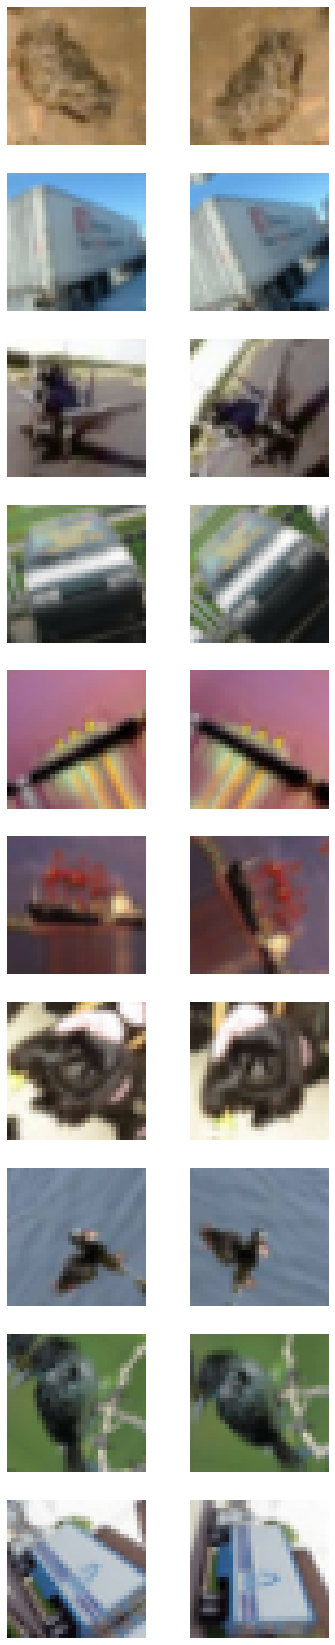

In [15]:
#CIFAR10
#A "reasonable" composite augmentation: initially copy pasted BT. We run this cell a few times to check it makes sense
#Also define encoder and model
fastai_encoder = create_encoder('xresnet18', n_in=3, pretrained=False)
model = create_barlow_twins_model(fastai_encoder, hidden_size=10,projection_size=10)# projection_size=1024)
#So aside from size, randomresizedcrop takes in two args: resize_scale and resize_ratio. So we want to put in 
#values for these which is tantamount to doing nothing
#So if we choose resize_scale=(1,1) then the images look the same.
#IMPORTANT: So this aug pipelines, insofar as I can tell at the moment, is tantamount to "do nothing"
#,resize_ratio=(0.75, 1.3333333333333333)
#aug_pipelines = get_barlow_twins_aug_pipelines(1000, rotate=True, jitter=True, bw=False, blur=True, resize_scale=(0.2, 1.0), resize_ratio=(0.75, 1.3333333333333333), rotate_deg=30, jitter_s=0.6, blur_s=(4, 32), same_on_batch=False, flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.3,stats=cifar_stats, cuda=True)

aug_pipelines = get_barlow_twins_aug_pipelines(size=32, rotate=True, jitter=False, bw=False, blur=False, resize_scale=(1.0, 1.0), resize_ratio=(1.0, 1.0), rotate_deg=90, jitter_s=0.6, blur_s=(4, 32), same_on_batch=False, flip_p=0.0, rotate_p=1.0, jitter_p=0.3, bw_p=0.3, blur_p=0.3,stats=cifar_stats, cuda=True)

#(size, rotate=True, jitter=True, bw=True, blur=True, resize_scale=(0.2, 1.0), resize_ratio=(0.75, 1.3333333333333333), rotate_deg=30, jitter_s=0.6, blur_s=(4, 32), same_on_batch=False, flip_p=0.5, rotate_p=0.3, jitter_p=0.3, bw_p=0.3, blur_p=0.3, stats=([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), cuda=True, xtra_tfms=[])

#learn = Learner(dls, model,ShortEpochCallback(0.001), cbs=[BarlowTwins(aug_pipelines, print_augs=True)])
learn = Learner(dls_tune, model, cbs=[BarlowTwins(aug_pipelines, print_augs=True)])

#dls.valid.bs = len(dls.valid_ds) #Set the validation dataloader batch size to be the length of the validation dataset

b = dls.one_batch()
learn._split(b)
learn('before_batch')
axes = learn.barlow_twins.show(n=10)

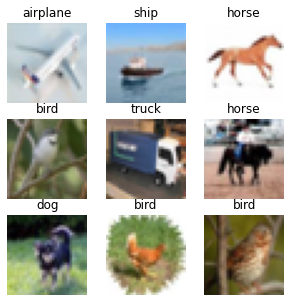

In [27]:
dls.show_batch(figsize=(5,5))    
  

In [31]:
get_batch_augs??

In [28]:
cifar_stats

([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])

In [97]:
#CIFAR10
device='cpu'  
path = untar_data(URLs.CIFAR)

dls = ImageDataLoaders.from_folder(path,items_tfms=Normalize.from_stats(*cifar_stats))
input('')
                                   




items = get_image_files(path / "train") + get_image_files(path / "test")

split = RandomSplitter(valid_pct=0.0) #randomly split training set into training and validation
#tds = Datasets(items,splits=split(items)) #Do we want this?
tds = Datasets(items, [PILImage.create, [parent_label, Categorize()]], splits=split(items)) #Or do we want this?
dls = tds.dataloaders(bs=600,num_workers=0, after_item=[ToTensor(), IntToFloatTensor()], device=device)


tfms = [[open_img, img2tensor],
        [parent_label, Categorize()]]
train_ds = Datasets(train, tfms)




KeyboardInterrupt: Interrupted by user

In [91]:
tds.dataloaders??

In [ ]:
mean=cifar_stats[0]
std=cifar_stats[1]
print(mean)
input()
dls = ImageDataLoaders.from_folder(path,num_workers=0,items_tfms=Normalize.from_stats(mean,std))

mean_r=0
mean_g=0
mean_b=0
for x,y in dls.train:
    mean_r += x[:,0,:,:].mean()
    #mean_g += x[:,1,:,:].mean()
    #mean_b += x[:,2,:,:].mean()
    
    print(mean_r)
    #print(mean_g)
    #print(mean_b)
    input()
    


[0.491, 0.482, 0.447]

TensorImage(0.5132)


In [63]:
cifar_stats

([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])